We imports all the necessary libraries for data generation, visualization, and Gaussian Mixture Model (GMM) implementation. It includes `seaborn` and `matplotlib.pyplot` for plotting, `numpy` for numerical operations, `scipy.stats.multivariate_normal` and `scipy.stats.norm` for probability distributions, and `warnings` for handling warnings. `random` is also imported, although it's not explicitly used in the provided GMM functions.

In [1]:
#import requred libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
import warnings
import random

warnings.filterwarnings('ignore')

np.random.seed(11)

Next, in this cell we generate two sets of 1D data (`data1`, `data2`) from normal distributions with different means and plots their distributions using `seaborn.distplot`. This is an initial exploration of generating and visualizing data that might have multiple modes, which is a common scenario for GMMs.

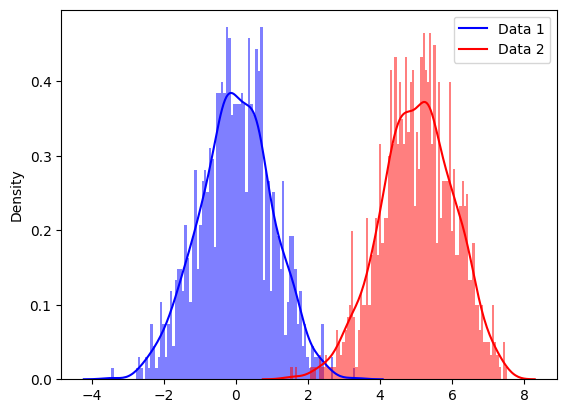

In [2]:
# Generate some data with multiple modes
data1 = np.random.normal(0, 1, 1000)
data2 = np.random.normal(5, 1, 1000)

# Plot the data using seaborn's distplot function
sns.distplot(data1, kde=True, hist=True, bins=100, color='b', hist_kws={'alpha': 0.5})
sns.distplot(data2, kde=True, hist=True, bins=100, color='r', hist_kws={'alpha': 0.5})

# Add a legend
plt.legend(['Data 1', 'Data 2'])

# Show the plot
plt.show()

This cell generates two sets of 2D data points (`data1`, `data2`) from multivariate normal distributions. Each distribution has a specified mean and covariance matrix. This data will be used to demonstrate 2D density plots later.

In [3]:
# Set the mean and covariance
mean1 = [0, 0]
mean2 = [2, 0]
cov1 = [[1, .7], [.7, 1]]
cov2 = [[.5, .4], [.4, .5]]

# Generate data from the mean and covariance
data1 = np.random.multivariate_normal(mean1, cov1, size=1000)
data2 = np.random.multivariate_normal(mean2, cov2, size=1000)

We now visualize the 2D data generated in the previous step. It uses `matplotlib.pyplot.scatter` to plot the individual data points for `data1` and `data2`. Additionally, `seaborn.kdeplot` is used to draw Kernel Density Estimate (KDE) contours for each dataset, showing the estimated probability density of the data in 2D space. The `x` and `y` keyword arguments are crucial for correctly plotting 2D KDEs in modern seaborn versions.

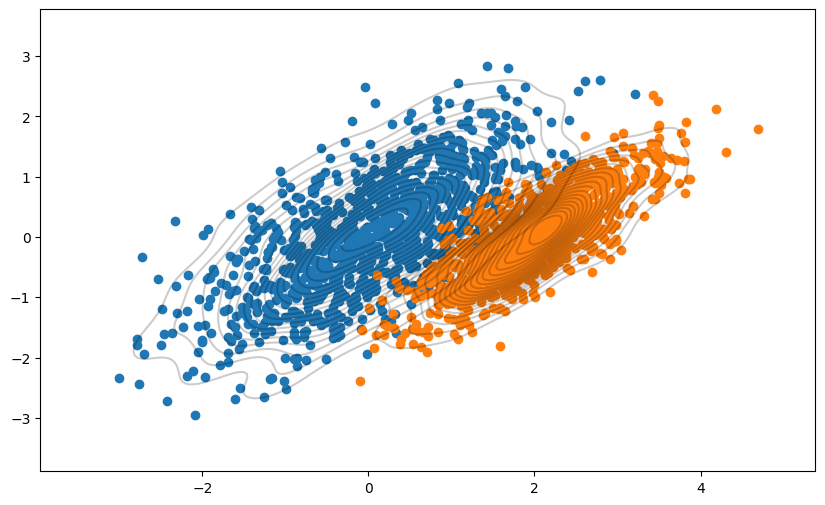

In [4]:
# Plot the given data
plt.figure(figsize=(10,6))

plt.scatter(data1[:,0],data1[:,1])
plt.scatter(data2[:,0],data2[:,1])

sns.kdeplot(x=data1[:, 0], y=data1[:, 1], levels=20, linewidth=10, color='k', alpha=0.2)
sns.kdeplot(x=data2[:, 0], y=data2[:, 1], levels=20, linewidth=10, color='k', alpha=0.2)

plt.grid(False)
plt.show()

This cell prepares 1D data for the Gaussian Mixture Model (GMM) implementation. It generates three distinct sets of data (`x1`, `x2`, `x3`) from normal distributions, each with its own mean (`mu`) and variance (`sigma`). These three sets are then concatenated into a single array `X`, representing the input data for the GMM, which is a mixture of three Gaussian components.

In [5]:
n_samples = 100
mu1, sigma1 = -5, 1.2
mu2, sigma2 = 5, 1.8
mu3, sigma3 = 0, 1.6

x1 = np.random.normal(loc = mu1, scale = np.sqrt(sigma1), size = n_samples)
x2 = np.random.normal(loc = mu2, scale = np.sqrt(sigma2), size = n_samples)
x3 = np.random.normal(loc = mu3, scale = np.sqrt(sigma3), size = n_samples)

X = np.concatenate((x1,x2,x3))

Now define a utility function `plot_pdf` to visualize 1D data distributions and their corresponding Probability Density Functions (PDFs). It takes the mean (`mu`), standard deviation (`sigma`), and a label as input. The function generates a sample of data from a normal distribution with the given parameters, plots a histogram of this data, and overlays the theoretical PDF curve. This function is instrumental for visualizing the progress of the GMM algorithm.

In [6]:
def plot_pdf(mu,sigma,label,alpha=0.5,linestyle='k--',density=True,color='green'):
    # Generate data from the normal distribution
    X = norm.rvs(mu, sigma, size=1000)

    # Plot the histogram of the generated data
    plt.hist(X, bins=50, density=density, alpha=alpha,label=label,color=color)

    # Plot the PDF curve
    x = np.linspace(X.min(), X.max(), 1000)
    y = norm.pdf(x, mu, sigma)
    plt.plot(x, y, linestyle)

This cell uses the `plot_pdf` function to visualize the three original Gaussian distributions from which the combined dataset `X` was generated. This plot serves as a reference to compare against the estimated components during the GMM training process. It helps to understand the underlying structure that the GMM aims to discover.

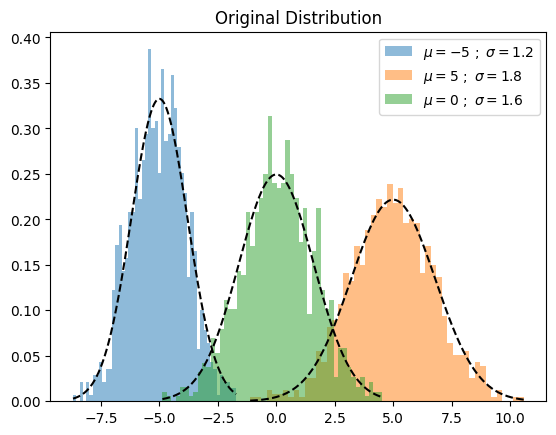

In [7]:
plot_pdf(mu1,sigma1,label=r"$\mu={} \ ; \ \sigma={}$".format(mu1,sigma1),color=None)
plot_pdf(mu2,sigma2,label=r"$\mu={} \ ; \ \sigma={}$".format(mu2,sigma2),color=None)
plot_pdf(mu3,sigma3,label=r"$\mu={} \ ; \ \sigma={}$".format(mu3,sigma3),color=None)
plt.title("Original Distribution")
plt.legend()
plt.show()

This cell defines the `random_init` function, which is the first step in the GMM algorithm: initialization. It randomly initializes the mixing coefficients (`pi`), means (`means`), and variances (`variances`) for a given number of Gaussian components. It also visualizes these initial random distributions, providing a starting point for the EM algorithm.

In [8]:
# Step 01: Initialize mean, covariance, and weights

def random_init(n_compenents):

    """Initialize means, weights and variance randomly"""

    pi = np.ones((n_compenents)) / n_compenents
    means = np.random.choice(X, n_compenents)
    variances = np.random.random_sample(size=n_compenents)
    plot_pdf(means[0],variances[0],'Random Init 01',)
    plot_pdf(means[1],variances[1],'Random Init 02',color='blue')
    plot_pdf(means[2],variances[2],'Random Init 03',color='orange')

    plt.title("Random Initialization")

    plt.legend()
    plt.show()

    return means,variances,pi

This cell defines the `step_expectation` function, which implements the Expectation (E) step of the EM algorithm for GMM. In this step, for each data point `X` and each component `j`, it calculates the probability that `X` belongs to component `j` (often called the 'responsibility' or 'weights'). This is done by evaluating the probability density function of each component at each data point.

In [9]:
# Step 02: Expectation Step (E step)
def step_expectation(X,n_components,means,variances):
    weights = np.zeros((n_components,len(X)))
    for j in range(n_components):
        weights[j,:] = norm(loc=means[j],scale=np.sqrt(variances[j])).pdf(X)
    return weights

### Verbose `step_expectation` Implementation

This version of `step_expectation` explicitly loops through each data point (`x_i`) to calculate its probability density under each Gaussian component. This makes the process more step-by-step and less reliant on advanced NumPy broadcasting/vectorization, which can be helpful for understanding the underlying mechanics.

In [10]:
def step_expectation_verbose(X, n_components, means, variances):
    """E Step (Verbose Implementation)

    Parameters
    ----------
    X : array-like, shape (n_samples,)
        The data.
    n_components : int
        The number of clusters
    means : array-like, shape (n_components,)
        The means of each mixture component.
    variances : array-like, shape (n_components,)
        The variances of each mixture component.

    Returns
    -------
    weights : array-like, shape (n_components,n_samples)
    """
    n_samples = len(X)
    # Initialize the weights array with zeros
    weights = np.zeros((n_components, n_samples))

    # Outer loop: Iterate through each Gaussian component
    for j in range(n_components):
        current_mean = means[j]
        current_variance = variances[j]
        # The `norm` function takes standard deviation, so we need sqrt of variance
        current_std = np.sqrt(current_variance)

        # Inner loop: Iterate through each data point
        for i in range(n_samples):
            data_point = X[i]
            # Calculate the PDF for the current data point under the current Gaussian component
            # This is p(x_i | component_j)
            weights[j, i] = norm(loc=current_mean, scale=current_std).pdf(data_point)

    return weights

# You can test this verbose version by calling it, for example:
# verbose_weights = step_expectation_verbose(X, n_compenents, means, variances)
# print(verbose_weights)

This cell defines the `step_maximization` function, which implements the Maximization (M) step of the EM algorithm for GMM. Based on the responsibilities calculated in the E-step, this function updates the parameters (means, variances, and mixing coefficients `pi`) of each Gaussian component to maximize the likelihood of the observed data. This step refines the model's parameters to better fit the data's underlying distributions.

In [11]:
# Step 03: Maximization Step (M step)
def step_maximization(X,weights,means,variances,n_compenents,pi):
    """M Step

    Parameters
    ----------
    X : array-like, shape (n_samples,)
        The data.
    weights : array-like, shape (n_components,n_samples)
        initilized weights array
    means : array-like, shape (n_components,)
        The means of each mixture component.
    variances : array-like, shape (n_components,)
        The variances of each mixture component.
    n_components : int
        The number of clusters
    pi: array-like (n_components,)
        mixture component weights

    Returns
    -------
    means : array-like, shape (n_components,)
        The means of each mixture component.
    variances : array-like, shape (n_components,)
        The variances of each mixture component.
    """
    r = []
    for j in range(n_compenents):
        r.append((weights[j] * pi[j]) / (np.sum([weights[i] * pi[i] for i in range(n_compenents)], axis=0)))

        means[j] = np.sum(r[j] * X) / (np.sum(r[j]))
        variances[j] = np.sum(r[j] * np.square(X - means[j])) / (np.sum(r[j]))

        pi[j] = np.mean(r[j])

    return variances,means,pi

This cell defines the `plot_intermediate_steps` function, a helper function to visualize the progress of the GMM training. It plots the original distributions (as a reference) and then overlays the currently estimated Gaussian components (means and variances) at various stages of the EM algorithm. This visualization helps in understanding how the GMM iteratively converges to the true underlying distributions.

In [12]:
def plot_intermediate_steps(means,variances,density=False,save=False,file_name=None):

    plot_pdf(mu1,sigma1,alpha=0.0,linestyle='r--',label='Original Distibutions')
    plot_pdf(mu2,sigma2,alpha=0.0,linestyle='r--',label='Original Distibutions')
    plot_pdf(mu3,sigma3,alpha=0.0,linestyle='r--',label='Original Distibutions')

    color_gen = (x for x in ['green','blue','orange'])

    for mu,sigma in zip(means,variances):
        plot_pdf(mu,sigma,alpha=0.5,label='d',color=next(color_gen))
    if save or file_name is not None:
        step = file_name.split("_")[1]
        plt.title(f"step: {step}")
        plt.savefig(f"steps/{file_name}.png",bbox_inches='tight')
    plt.show()

This cell defines the `train_gmm` function, which orchestrates the entire Gaussian Mixture Model (GMM) training process. It initializes the model parameters using `random_init`, then iteratively performs the Expectation (E) step via `step_expectation` and the Maximization (M) step via `step_maximization` for a specified number of iterations (`n_steps`). Optionally, it visualizes the intermediate steps of the model's convergence using `plot_intermediate_steps`.

In [13]:
# training
def train_gmm(data,n_compenents=3,n_steps=50, plot_intermediate_steps_flag=True):
    """ Training step of the GMM model

    Parameters
    ----------
    data : array-like, shape (n_samples,)
        The data.
    n_components : int
        The number of clusters
    n_steps: int
        number of iterations to run
    """


    means,variances,pi = random_init(n_compenents)
    for step in range(n_steps):
        weights = step_expectation(data,n_compenents,means,variances)
        variances,means,pi = step_maximization(X, weights, means, variances, n_compenents, pi)
        if plot_intermediate_steps_flag:plot_intermediate_steps(means,variances,)#file_name=f'step_{step+1}')
    plot_intermediate_steps(means,variances)

This cell initiates the training of the Gaussian Mixture Model by calling the `train_gmm` function with the pre-generated dataset `X`. It specifies `n_steps=30` for the number of iterations and `plot_intermediate_steps_flag=True` to visualize the convergence process at each step. This execution demonstrates the GMM algorithm in action, showing how the estimated Gaussian components gradually align with the true underlying distributions.

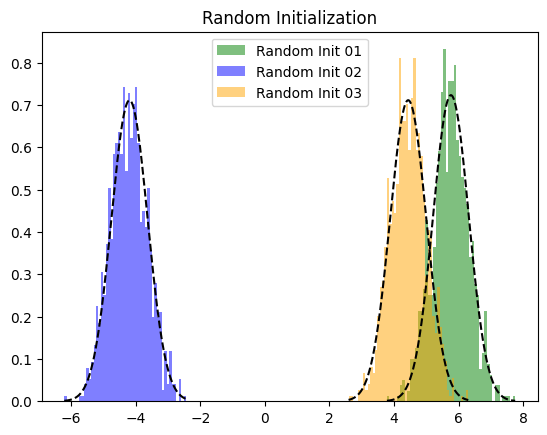

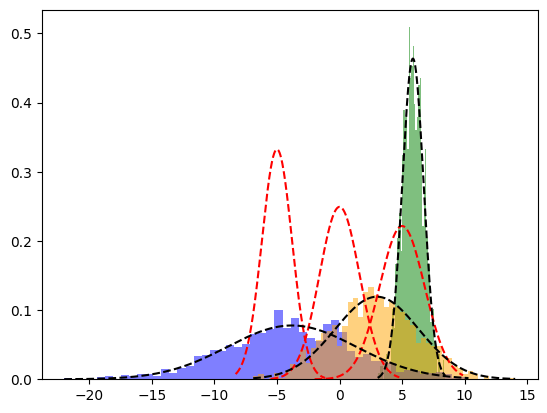

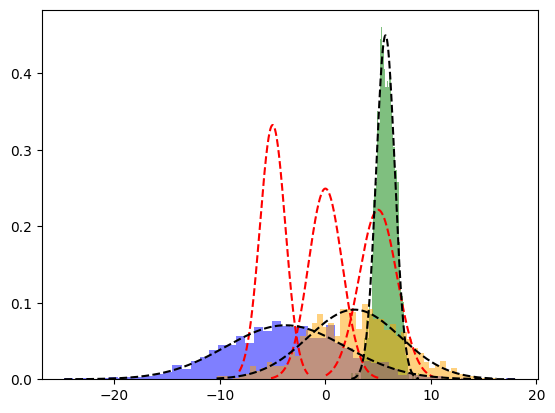

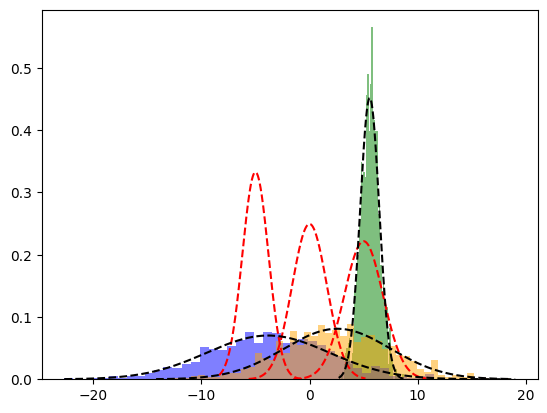

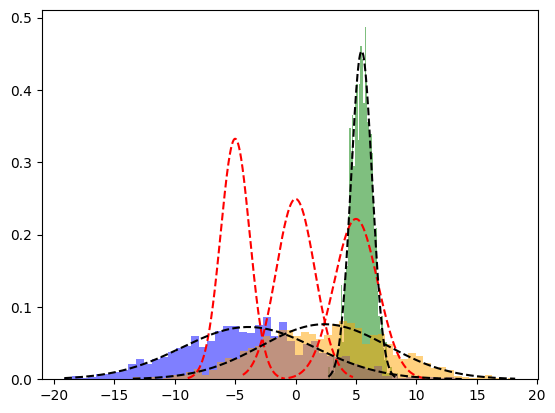

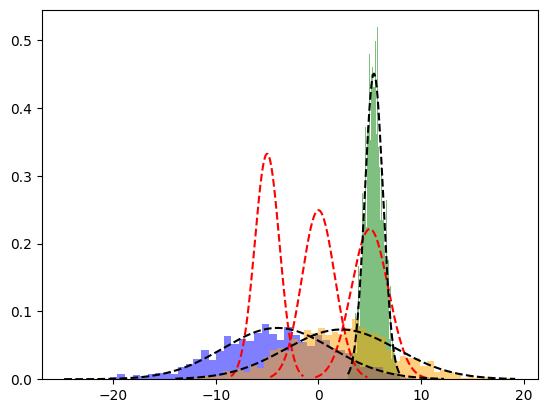

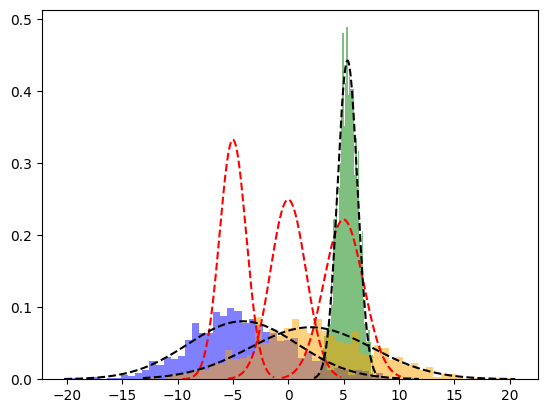

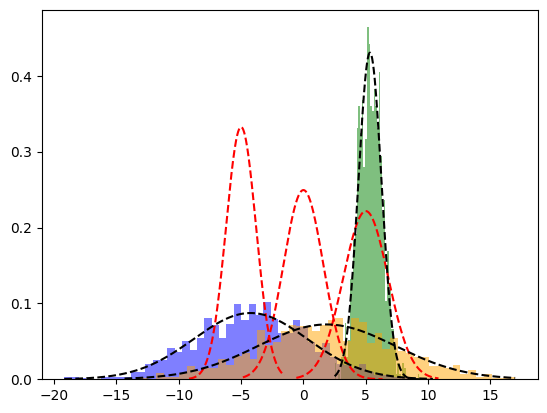

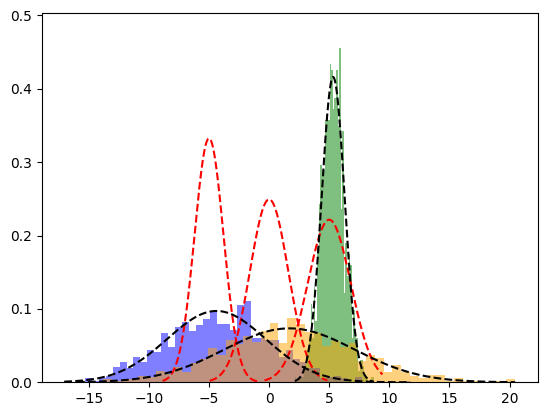

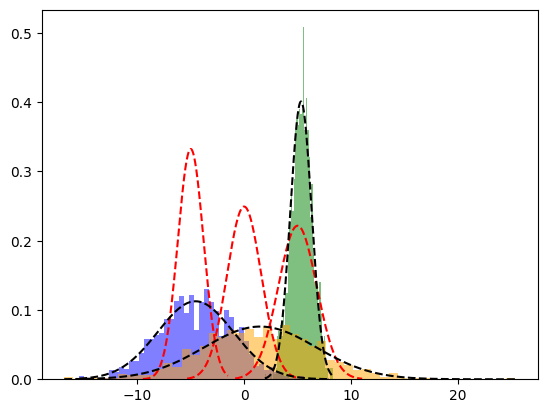

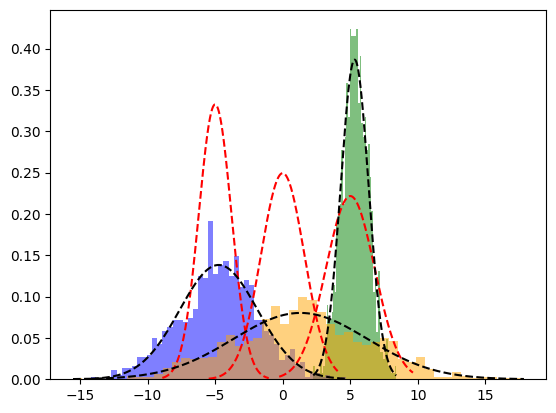

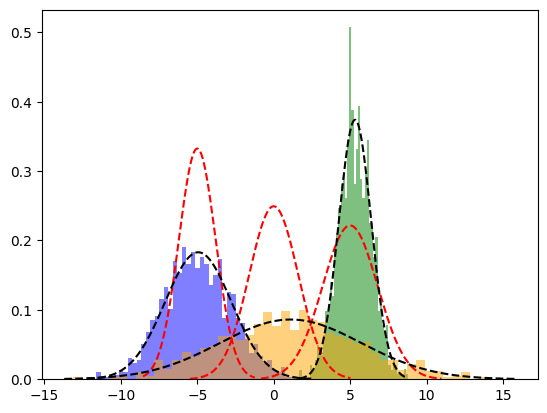

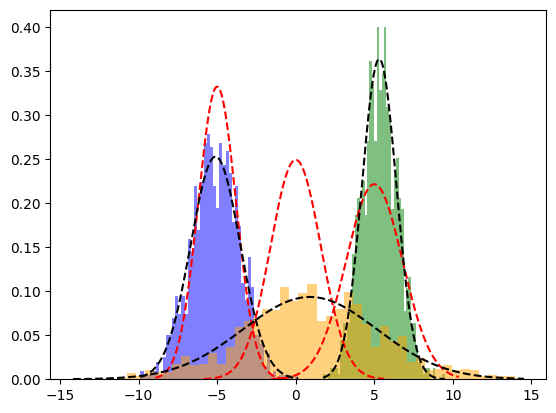

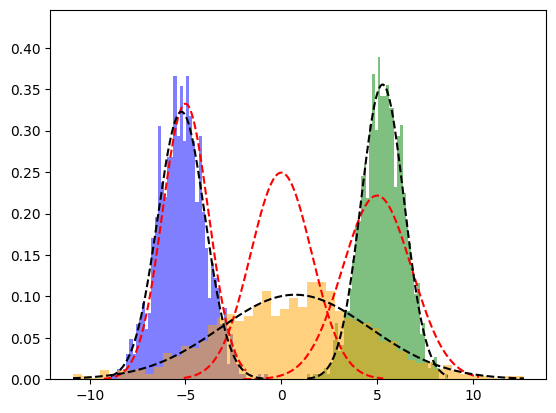

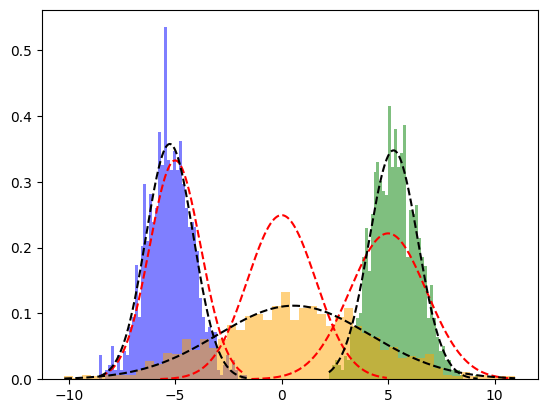

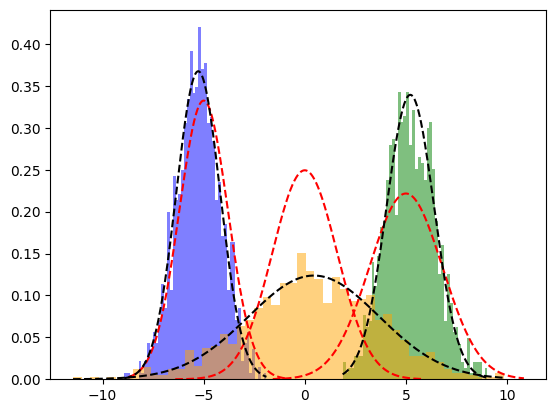

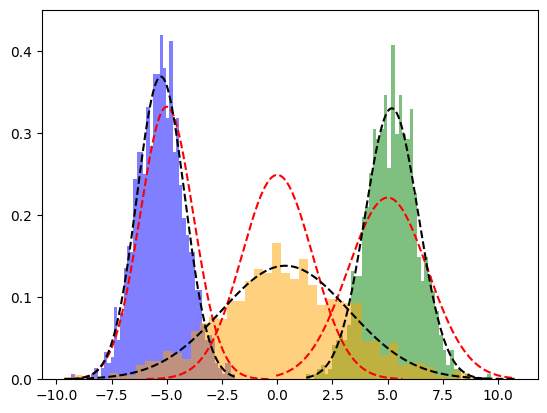

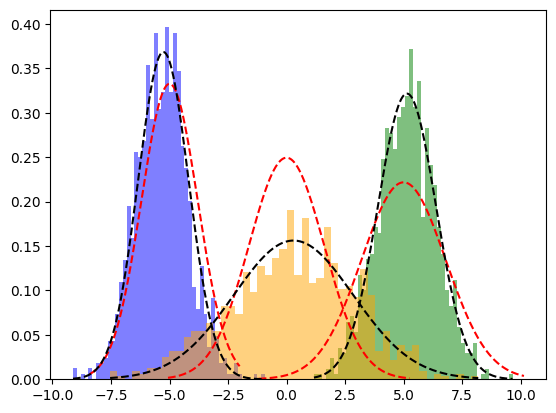

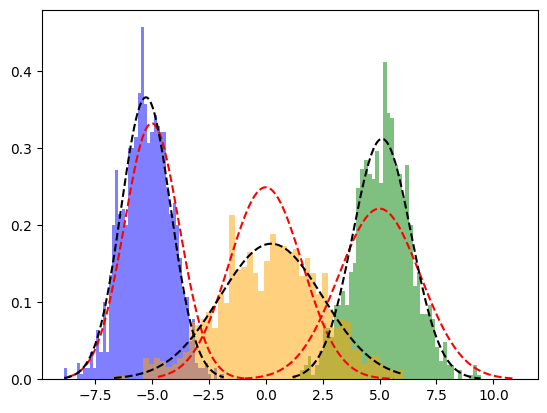

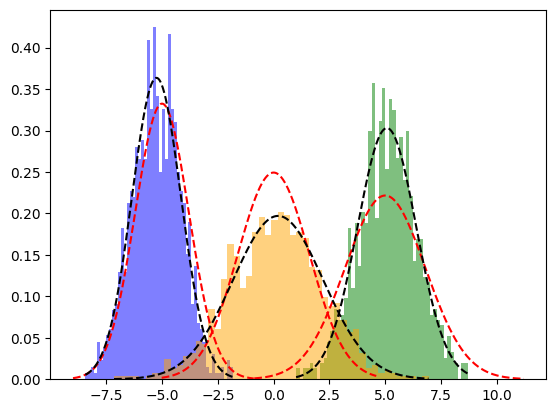

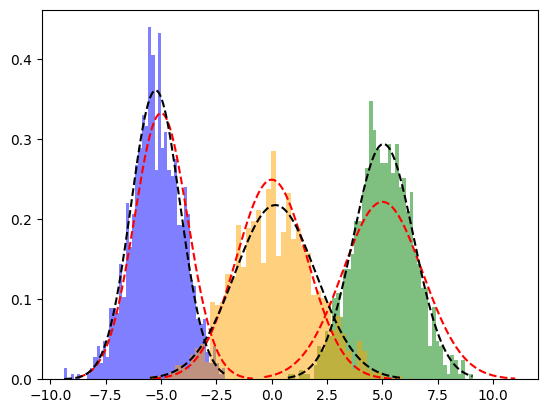

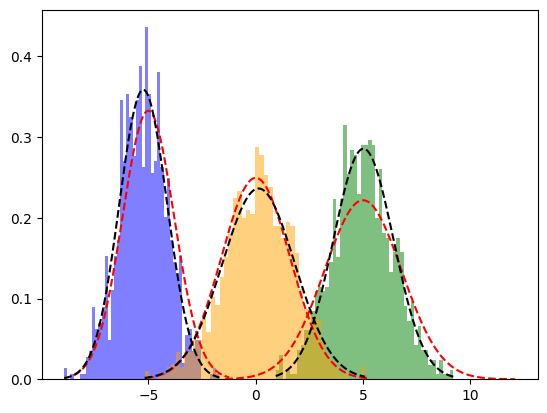

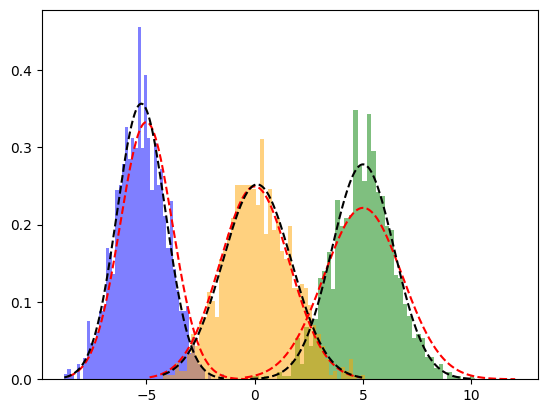

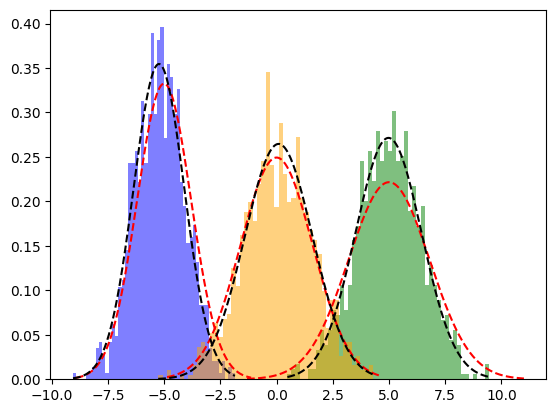

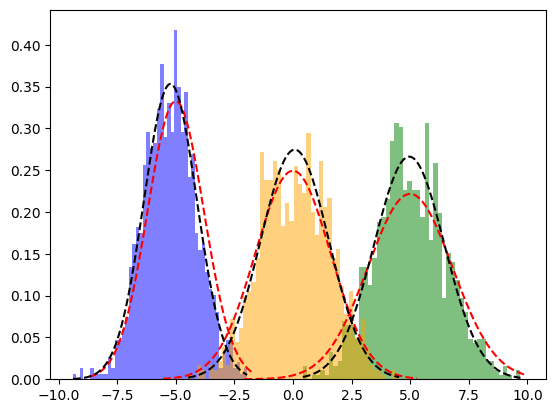

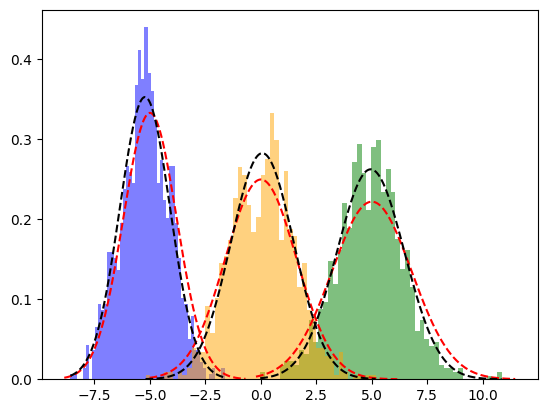

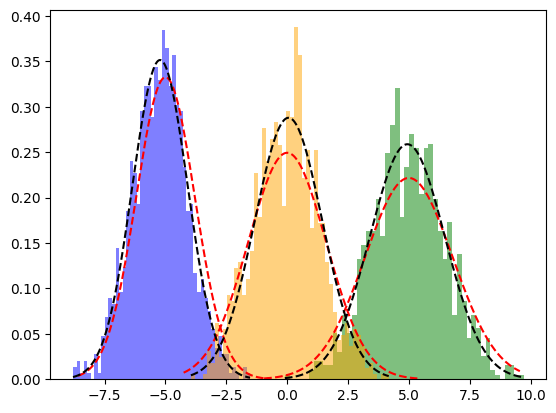

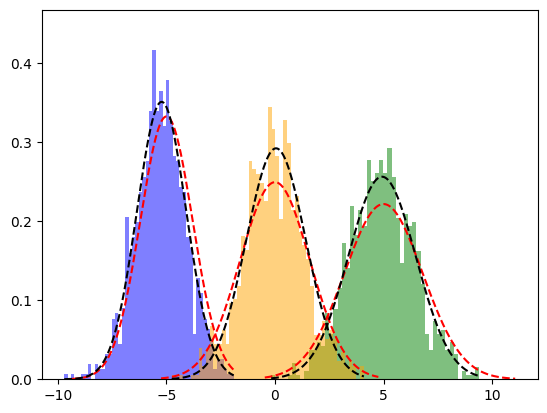

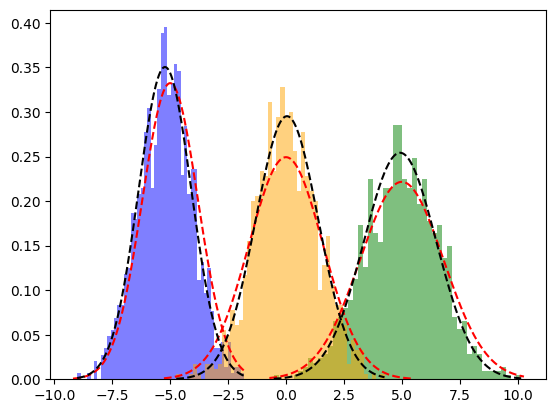

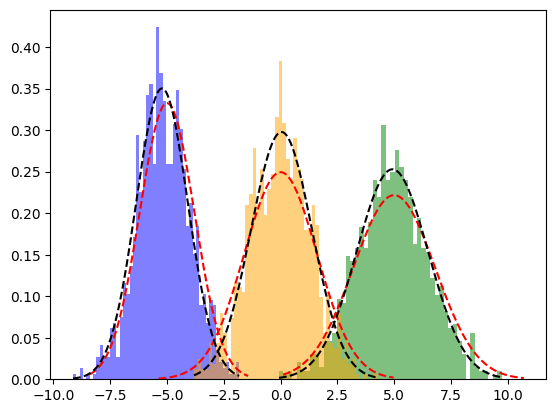

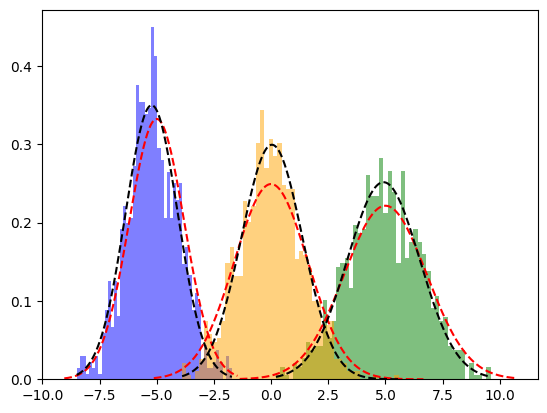

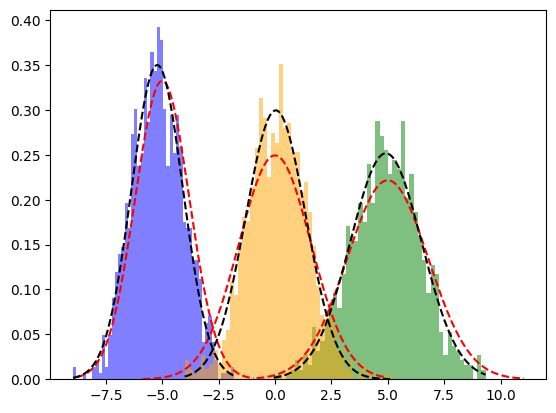

In [14]:
train_gmm(X,n_steps=30,plot_intermediate_steps_flag=True)